In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
biogrid = '../out/biogrid.all.txt'
biogrid_genetic = '../out/biogrid.genetic.txt'
obo = '../out/SGD_slim.obo'
gaf = '../out/SGD_slim.tsv'
threshold = 0.5

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy

In [4]:
def cohens(x, y):
    r"""Effect size metric through Cohen's *d* metric
    :param x: first vector
    :param y: second vector
    :return: absolute effect size value
    The Cohen's effect size *d* is defined as the difference
    between two means divided by a standard deviation of the data.
    .. math::
        d = \frac{\bar{x}_1 - \bar{x}_2}{s}
    For two independent samples, the *pooled standard deviation* is used
    instead, which is defined as:
    .. math::
        s = \sqrt{  \frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2} }
    A Cohen's *d* is frequently used in estimating sample sizes for
    statistical testing: a lower *d* value indicates the necessity of
    larger sample sizes, and vice versa.
    .. note:: we return the absolute value
    :references: https://en.wikipedia.org/wiki/Effect_size
    """
    x = np.array(x)
    y = np.array(y)

    Nx = len(x) - 1.  # note the dot to cast to float
    Ny = len(y) - 1.
    # mean difference:
    md = np.abs(x.mean() - y.mean())
    # here, we want same as in R that is unbiased variance
    # so we use ddof = 1
    xv = x.var(ddof=1)
    yv = y.var(ddof=1)
    csd = Nx * xv + Ny * yv
    csd /= Nx + Ny  # make sure this is float
    csd = np.sqrt(csd)

    return md / csd

In [5]:
def compare(w, df,
            iterations=10,
            name='',
            threshold=0.1):
    idx = df.index.intersection(w.index)

    y = w.loc[idx]
    df = df.loc[idx]

    res = []
    for x in df.loc[y[y > threshold].index].values:
        res.append((name, 'real', x))
    for i in range(iterations):
        for x in df.loc[y[y <= threshold].sample(n=y[y > threshold].shape[0],
                                                 replace=False).index]:
            res.append((name, 'random%d' % i, x))
    for x in df.loc[y[y <= threshold].index]:
        res.append((name, 'random', x))
    r = pd.DataFrame(res,
                     columns=['name', 'set', 'v'])

    return r

In [6]:
def go_enrich(pop, study,
              go, obodag,
              pvalue=0.01):
    res = []
    goeaobj = GOEnrichmentStudy(pop,
                                go, obodag,
                                propagate_counts=False,
                                alpha=0.05,
                                methods=['fdr_bh'],
                                log=None)
    goe = goeaobj.run_study(study,
                            log=None)
    for xx in goe:
        res.append([xx.goterm.id,
                    xx.goterm.namespace,
                    xx.goterm.depth,
                    xx.goterm.name,
                    '%d/%d' % xx.ratio_in_study,
                    '%d/%d' % xx.ratio_in_pop,
                    xx.p_uncorrected,
                    xx.p_fdr_bh])
    g = pd.DataFrame(res,
                     columns=['go',
                              'go_namespace',
                              'go_depth',
                              'go_name',
                              'ratio_in_study',
                              'ratio_in_population',
                              'pvalue',
                              'qvalue'])
    g = g[g['qvalue'] <= pvalue]
    return g

In [7]:
obodag = GODag(obo)
go = {}
rgo = {}
for l in open(gaf):
    gene, gos = l.rstrip().split()
    go[gene] = set(gos.split(';')) - {''}
    for gterm in set(gos.split(';')) - {''}:
        rgo[gterm] = rgo.get(gterm, set())
        rgo[gterm].add(gene)

../out/SGD_slim.obo: fmt(1.2) rel(None) 265 GO Terms


In [8]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [9]:
it = {}
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    it[g1] = it.get(g1, 0)
    it[g2] = it.get(g2, 0)
    it[g1] += 1
    it[g2] += 1

In [10]:
gi = pd.read_table(biogrid_genetic)
git = {}
for g1, g2 in gi[(gi['interaction'] == 'negative') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    git[g1] = git.get(g1, 0)
    git[g2] = git.get(g2, 0)
    git[g1] += 1
    git[g2] += 1
pit = {}
for g1, g2 in gi[(gi['interaction'] == 'positive') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    pit[g1] = pit.get(g1, 0)
    pit[g2] = pit.get(g2, 0)
    pit[g1] += 1
    pit[g2] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [11]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
m = m.loc[(slice(None), genes),]
# p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
# pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
# pgenes = set(pgenes[pgenes == True].index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


Y55 4190
YPS 4093
S288C 4889
UWOP 4014

total 3786


In [12]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [13]:
strains = {y
           for x in d.index
           for y in x[:2]}

In [14]:
d = d.reset_index()

In [15]:
x1 = d.rename(columns={'strain1': 'strain',
                       'phenotype1': 'phenotype',
                       'strain2': 'other',
                       'phenotype2': 'otherp'}
             ).T.sort_index().T
x2 = d.rename(columns={'strain2': 'strain',
                       'phenotype2': 'phenotype',
                       'strain1': 'other',
                       'phenotype1': 'otherp'}
             ).T.sort_index().T
x = pd.concat([x1, x2]).reindex()

y = x[(x['phenotype'])]

In [16]:
e = y[(y['phenotype']) &
      (y['qvalue'] < 0.01)].set_index(['gene',
                                       'condition'])
w = (e.groupby('gene')['phenotype'].count() /
     (e.groupby('gene')['phenotype'].count() +
      y[(y['phenotype']) &
        (y['otherp']) &
        (y['qvalue'] >=  0.01)].groupby('gene')['phenotype'].count()))
w[np.isnan(w)] = 0

In [17]:
e = y[(y['phenotype']) &
      (y['qvalue'] < 0.01)].set_index(['gene',
                                       'condition'])
w1 = (e.groupby('gene')['phenotype'].count() /
     (y[(y['phenotype']) &
        (y['qvalue'] >=  0.01)].groupby('gene')['phenotype'].count()))
w1[np.isnan(w1)] = 0

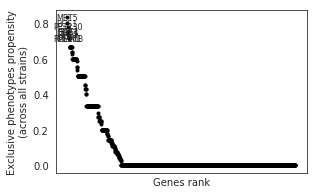

In [18]:
plt.figure(figsize=(4.5, 3))

x = w
idx = x.sort_values(ascending=False).index

xx = x.sort_values(ascending=False).to_frame()
xx['rank'] = range(xx.shape[0])

obj = plt.plot(xx['rank'],
               xx['phenotype'],
               'k.')

texts = [plt.text(i, y, gn.get(k, k),
                  ha='center',
                  va='center',
                  size=8)
         for i, (k, y) in enumerate(x.sort_values(ascending=False).head(10).iteritems())]
# iterations = adjust_text(texts,
#                          arrowprops=dict(arrowstyle='-',
#                                          color='k'),
#                          force_text=0.1,
#                          #add_objects=obj
#                         )

# plt.gca().invert_yaxis()

# plt.axhline(0.6,
#             color='grey',
#             ls='dashed')

plt.xlabel('Genes rank')
plt.xticks([])
# plt.ylim(-0.01, 70)
plt.ylabel('Exclusive phenotypes propensity\n(across all strains)')

plt.savefig('exclusiveness_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('exclusiveness_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [19]:
go_enrich(set(genes),
          set(w[w > 0].index),
          obodag=obodag, go=go)


Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact

Run GOEA Gene Ontology Analysis: current study set of 242 IDs ...


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue
0,GO:0016197,biological_process,1,endosomal transport,13/242,62/3786,1.066429e-04,0.005688
1,GO:0007005,biological_process,1,mitochondrion organization,23/242,161/3786,1.961806e-04,0.007449
2,GO:0045333,biological_process,2,cellular respiration,11/242,50/3786,2.327869e-04,0.007449
3,GO:0071554,biological_process,1,cell wall organization or biogenesis,20/242,135/3786,4.032130e-04,0.009241
4,GO:0006360,biological_process,1,transcription by RNA polymerase I,7/242,23/3786,4.042784e-04,0.009241
66,GO:0012505,cellular_component,1,endomembrane system,58/242,593/3786,4.780687e-04,0.009561
113,GO:0008150,biological_process,0,biological_process,32/242,999/3786,5.064818e-07,0.000081
148,GO:0003674,molecular_function,0,molecular_function,66/242,1518/3786,2.385942e-05,0.001909


In [20]:
go_enrich(set(genes),
          set(w[w > 0].index),
          obodag=obodag, go=go).to_csv('go_terms.tsv',
                                       sep='\t',
                                       index=False)


Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact

Run GOEA Gene Ontology Analysis: current study set of 242 IDs ...


In [21]:
w.shape[0], w[w > 0].shape[0]

(1026, 242)

In [22]:
pm = (m.reset_index().groupby('gene')['phenotype'].sum()
      /
      m.reset_index().groupby('gene')['phenotype'].count())

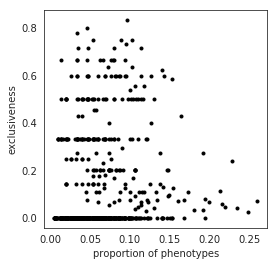

In [23]:
plt.figure(figsize=(4, 4))

idx = pm.index.intersection(w.index)

plt.plot(pm.loc[idx],
         w.loc[idx],
         'k.')

plt.xlabel('proportion of phenotypes')
plt.ylabel('exclusiveness');

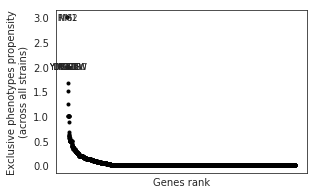

In [24]:
plt.figure(figsize=(4.5, 3))

x = w1
idx = x.sort_values(ascending=False).index

xx = x.sort_values(ascending=False).to_frame()
xx['rank'] = range(xx.shape[0])

obj = plt.plot(xx['rank'],
               xx['phenotype'],
               'k.')

texts = [plt.text(i, y, gn.get(k, k),
                  ha='center',
                  va='center',
                  size=8)
         for i, (k, y) in enumerate(x.sort_values(ascending=False).head(10).iteritems())]
# iterations = adjust_text(texts,
#                          arrowprops=dict(arrowstyle='-',
#                                          color='k'),
#                          force_text=0.1,
#                          #add_objects=obj
#                         )

# plt.gca().invert_yaxis()

# plt.axhline(0.6,
#             color='grey',
#             ls='dashed')

plt.xlabel('Genes rank')
plt.xticks([])
# plt.ylim(-0.01, 70)
plt.ylabel('Exclusive phenotypes propensity\n(across all strains)')

plt.savefig('exclusiveness_all_alternative.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('exclusiveness_all_alternative.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [25]:
!curl --silent http://eggnogdb.embl.de/download/eggnog_4.5/data/fuNOG/fuNOG.members.tsv.gz | zcat > fuNOG.txt

In [26]:
dnog = {}
species = set()
for l in open('fuNOG.txt'):
    _, _, _, _, _, x = l.rstrip().split('\t')
    for g in x.split(','):
        s = g.split('.')
        org = s[0]
        gene = '.'.join(s[1:])
        species.add(org)
        if org == '4932':
            dnog[gene] = len({g.split('.')[0] for g in x.split(',')})
nog = pd.Series(dnog) / len(species)

In [27]:
disorder = '../out/disorder.txt'

In [28]:
dis = pd.read_csv(disorder, sep='\t', header=None)

In [29]:
dis = dis.set_index(0)[2]

In [30]:
it = pd.Series(it)
git = pd.Series(git)
pit = pd.Series(pit)

# it = it / it.max()
# git = git / git.max()
# pit = pit / pit.max()

In [31]:
res = []
for df, name in zip([it,
                     git, pit,
                     nog, dis],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive',
                     'conservation',
                     'disorder']):
    res.append(compare(w, df, name=name,
                       threshold=0))
r = pd.concat(res)

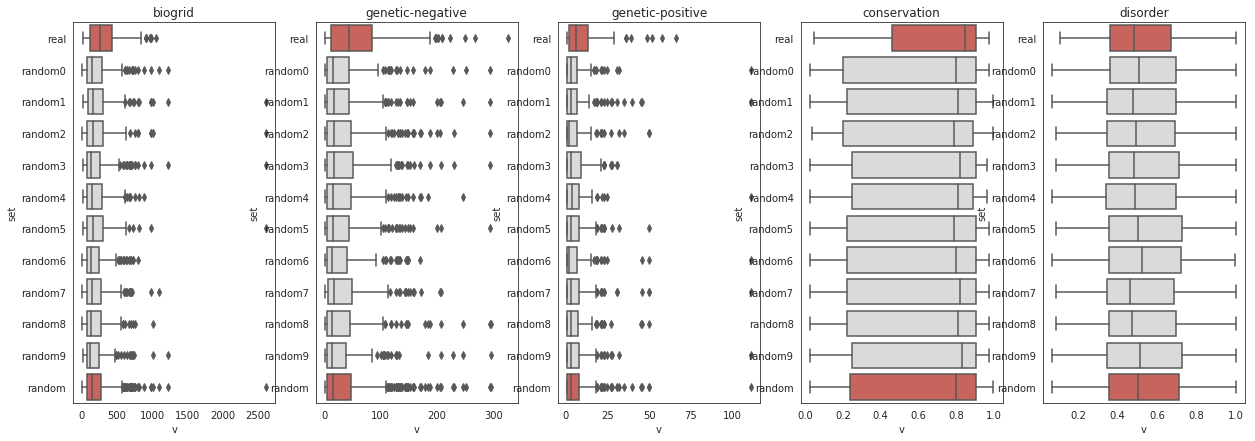

In [32]:
plt.figure(figsize=(21, 7))

for i, name in enumerate(r['name'].unique()):
    plt.subplot(1, 5, i+1)
    
    sns.boxplot(data=r[r['name'] == name],
                x='v',
                y='set',
                palette=[sns.xkcd_rgb['pale red']] +
                        [sns.xkcd_rgb['light grey']] * 10)
    
    plt.title(name);

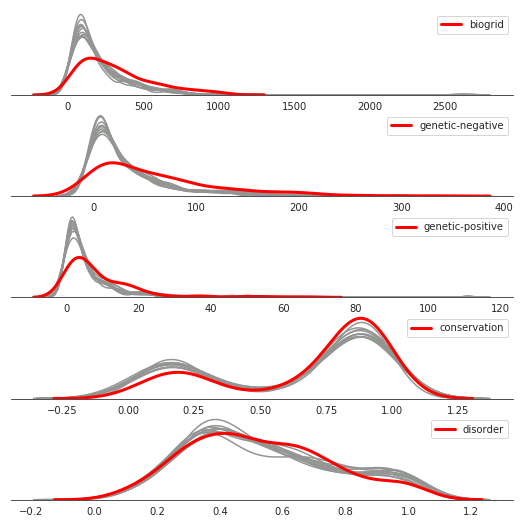

In [33]:
plt.figure(figsize=(9, 9))

for i, name in enumerate(r['name'].unique()):
    plt.subplot(5, 1, i+1)
    
    sns.kdeplot(r[(r['name'] == name) &
                  (r['set'] == 'real')]['v'],
                color='r',
                label=name,
                lw=3)
    for x in r[(r['name'] == name) &
               (r['set'] != 'real')]['set'].unique():
        sns.kdeplot(r[(r['name'] == name) &
                      (r['set'] == x)]['v'],
                    color=sns.xkcd_rgb['grey'],
                    label='_',
                    zorder=0)
    
#     plt.xlim(-0.05, 1.05)
    plt.yticks([])
    
sns.despine(left=True)

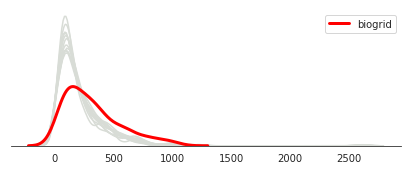

In [34]:
plt.figure(figsize=(7, 2.5))

name = 'biogrid'

sns.kdeplot(r[(r['name'] == name) &
              (r['set'] == 'real')]['v'],
            color='r',
            label=name,
            lw=3)
for x in r[(r['name'] == name) &
           (r['set'] != 'real')]['set'].unique():
    sns.kdeplot(r[(r['name'] == name) &
                  (r['set'] == x)]['v'],
                color=sns.xkcd_rgb['light grey'],
                label='_',
                alpha=1,
                zorder=0)

# plt.xlim(-0.05, 0.405)
plt.yticks([])
    
sns.despine(left=True)

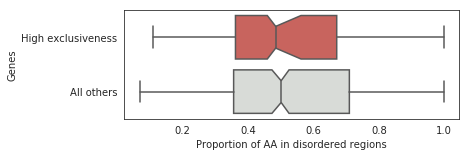

In [35]:
plt.figure(figsize=(6, 2))

name = 'disorder'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('Genes')
plt.xlabel('Proportion of AA in disordered regions')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others'])

plt.savefig('disorder.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('disorder.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [36]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.06082211867963716, pvalue=0.4911841923496412)

In [37]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.0701484572797037

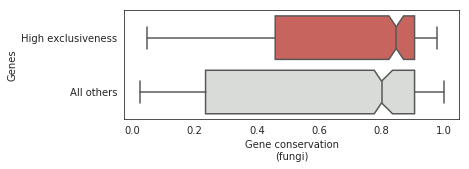

In [38]:
plt.figure(figsize=(6, 2))

name = 'conservation'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('Genes')
plt.xlabel('Gene conservation\n(fungi)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others'])

plt.savefig('conservation.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('conservation.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [39]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.10175847987332276, pvalue=0.06526535656473363)

In [40]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.19690987983561803

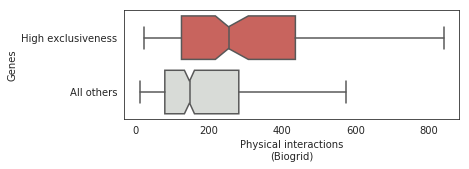

In [41]:
plt.figure(figsize=(6, 2))

name = 'biogrid'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('Genes')
plt.xlabel('Physical interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others'])

plt.savefig('biogrid.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [42]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.2648534837211035, pvalue=5.1859275273974734e-11)

In [43]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.4944370871542943

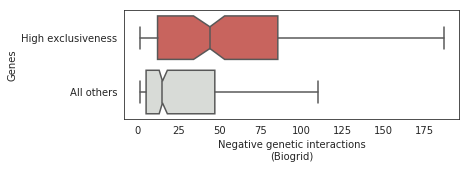

In [44]:
plt.figure(figsize=(6, 2))

name = 'genetic-negative'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('Genes')
plt.xlabel('Negative genetic interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others'])

plt.savefig('biogrid-genetic.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid-genetic.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [45]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.2562848507145073, pvalue=1.0070055114898762e-09)

In [46]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.5330652154527096

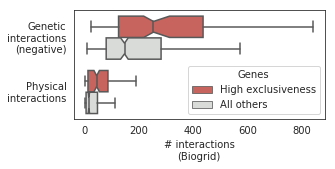

In [47]:
plt.figure(figsize=(4.5, 2))

names = ['genetic-negative',
         'biogrid']
sns.boxplot(data=r[(r['name'].isin(names)) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='name',
            hue='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('')
plt.xlabel('# interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['Genetic\ninteractions\n(negative)',
            'Physical\ninteractions'])

l = plt.legend(title='Genes')
l.get_texts()[0].set_text('High exclusiveness')
l.get_texts()[1].set_text('All others')

plt.savefig('biogrid-both.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid-both.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [48]:
res = []
for df, name in zip([it,
                     git, pit],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive']):
    res.append(compare(w1, df, name=name,
                       threshold=0))
r = pd.concat(res)

In [49]:
name = 'biogrid'
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.21664051465590028, pvalue=5.5196395885024884e-17)

In [50]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.47744855994922725

In [51]:
name = 'genetic-negative'
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.20113454920512142, pvalue=2.4701778220464597e-13)

In [52]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.4876622925290878

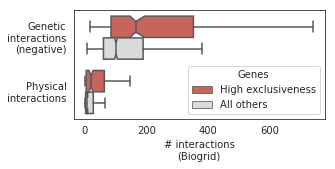

In [53]:
plt.figure(figsize=(4.5, 2))

names = ['genetic-negative',
         'biogrid']
sns.boxplot(data=r[(r['name'].isin(names)) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='name',
            hue='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('')
plt.xlabel('# interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['Genetic\ninteractions\n(negative)',
            'Physical\ninteractions'])

l = plt.legend(title='Genes')
l.get_texts()[0].set_text('High exclusiveness')
l.get_texts()[1].set_text('All others')

plt.savefig('biogrid-both-alternative.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid-both-alternative.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [54]:
w.name = 'exclusiveness'
w1.name = 'exclusiveness-alternative'
x = w.to_frame().join(w1.to_frame(), how='outer')

In [55]:
x.sort_values('exclusiveness', ascending=False).to_csv('exclusiveness.tsv')

In [56]:
(m.loc[(slice(None), w[w > 0].index),].reset_index().groupby('gene')['phenotype'].sum() / 
m.loc[(slice(None), w[w > 0].index),].reset_index().groupby('gene')['phenotype'].count()).mean()

0.07888703002288683

In [57]:
(m.loc[(slice(None), w[w > 0].index),].reset_index().groupby('gene')['phenotype'].sum() / 
m.loc[(slice(None), w[w > 0].index),].reset_index().groupby('gene')['phenotype'].count()).std()

0.04774948319376646

In [58]:
c = m.groupby('gene')['phenotype'].sum() / m.groupby('gene')['phenotype'].count()

In [59]:
ww = w.loc[c[c > 0.05].index.intersection(w.index)]

In [60]:
(m.loc[(slice(None), ww[ww == 0].index),].reset_index().groupby('gene')['phenotype'].sum() / 
m.loc[(slice(None), ww[ww == 0].index),].reset_index().groupby('gene')['phenotype'].count()).mean()

0.07422543337215183

In [61]:
(m.loc[(slice(None), ww[ww == 0].index),].reset_index().groupby('gene')['phenotype'].sum() / 
m.loc[(slice(None), ww[ww == 0].index),].reset_index().groupby('gene')['phenotype'].count()).std()

0.02295686386798717

In [62]:
res = []
for df, name in zip([it,
                     git, pit],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive']):
    res.append(compare(ww, df, name=name,
                       threshold=0))
r = pd.concat(res)

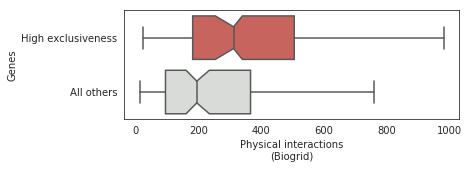

In [63]:
plt.figure(figsize=(6, 2))

name = 'biogrid'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('Genes')
plt.xlabel('Physical interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others']);

In [64]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.23526277057375594, pvalue=3.41079449936996e-05)

In [65]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.341010656111645

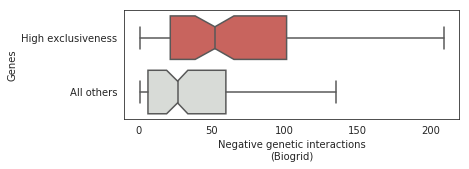

In [66]:
plt.figure(figsize=(6, 2))

name = 'genetic-negative'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('Genes')
plt.xlabel('Negative genetic interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others']);

In [67]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.21885057471264366, pvalue=0.0002546713536257418)

In [68]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.4459634819619174

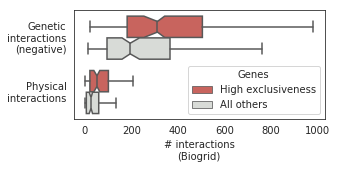

In [69]:
plt.figure(figsize=(4.5, 2))

names = ['genetic-negative',
         'biogrid']
sns.boxplot(data=r[(r['name'].isin(names)) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='name',
            hue='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('')
plt.xlabel('# interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['Genetic\ninteractions\n(negative)',
            'Physical\ninteractions'])

l = plt.legend(title='Genes')
l.get_texts()[0].set_text('High exclusiveness')
l.get_texts()[1].set_text('All others');

In [70]:
res = []
for df, name in zip([it,
                     git, pit],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive']):
    res.append(compare(w1, df, name=name,
                       threshold=0))
r = pd.concat(res)

In [71]:
name = 'biogrid'
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.21664051465590028, pvalue=5.5196395885024884e-17)

In [72]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.47744855994922725

In [73]:
name = 'genetic-negative'
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.20113454920512142, pvalue=2.4701778220464597e-13)

In [74]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.4876622925290878

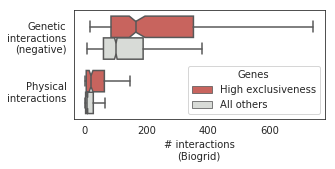

In [75]:
plt.figure(figsize=(4.5, 2))

names = ['genetic-negative',
         'biogrid']
sns.boxplot(data=r[(r['name'].isin(names)) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='name',
            hue='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False,
            bootstrap=1000
           )
    
plt.ylabel('')
plt.xlabel('# interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['Genetic\ninteractions\n(negative)',
            'Physical\ninteractions'])

l = plt.legend(title='Genes')
l.get_texts()[0].set_text('High exclusiveness')
l.get_texts()[1].set_text('All others');